In [63]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import coo_matrix

In [79]:
# Load the provided data
alphas_77 = np.load('hs_tomography/alphas_77.npy')
y_77 = np.load('hs_tomography/y_77.npy')
X_77 = np.load('hs_tomography/X_77.npy', allow_pickle=True)
X_example = np.load('hs_tomography/X_example.npy', allow_pickle=True)

alpha: -33
alpha: 1
alpha: 42


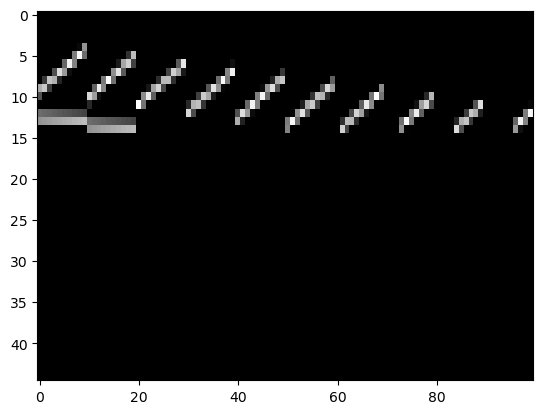

In [84]:

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def construct_X(M, alphas, Np=None):
    """
    Construct the matrix X from the given parameters.
    """
    if Np is None:
        Np = round_up_to_odd(np.sqrt(2) * M)

    D = M * M
    N = len(alphas) * Np
    i_indices = []
    j_indices = []
    weights = []

    # Pixel coordinates centered around (0,0)
    a0 = b0 = (M - 1) / 2
    h = 1  # Pixel distance
    j_a, j_b = np.mgrid[0:M, 0:M]
    C0 = a0 + j_a.flatten() * h
    C1 = b0 + j_b.flatten() * h
    C = np.vstack((C0, C1))

    
    # Pixel coordinates
    for alpha in alphas:
        print(f"alpha: {alpha}")
        rad = np.deg2rad(alpha)

        # Unit vector n
        n = np.array([np.cos(rad), np.sin(rad)])
        
        # Linear projection p
        p = np.dot(n.T, C) + ((Np - 1) / 2)

        left_indices = np.floor(p).astype(int)
        right_indices = left_indices + 1
        
        right_weight = p - left_indices
        left_weight = 1.0 - right_weight
        
        valid_mask = (left_indices >= 0) & (right_indices < Np)
        
        i_indices.extend(left_indices[valid_mask])
        j_indices.extend(np.arange(D)[valid_mask])
        weights.extend(left_weight[valid_mask])
        
        i_indices.extend(right_indices[valid_mask])
        j_indices.extend(np.arange(D)[valid_mask])
        weights.extend(right_weight[valid_mask])
        
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    return X

# Example usage
M = 77
Np = 109

X = construct_X(M=10, alphas=[-33, 1, 42])
plt.imshow(X.toarray(), cmap='gray', aspect='auto')
plt.show()


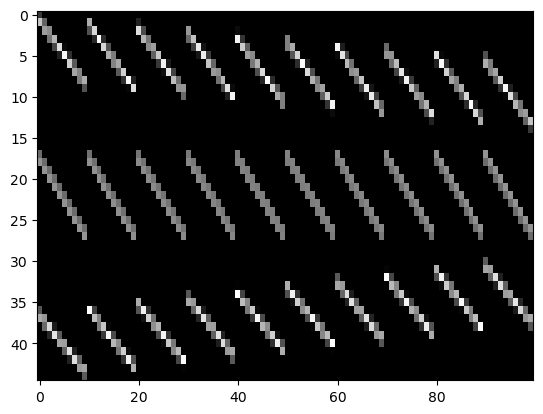

In [81]:
plt.imshow(X_example, cmap='gray', aspect='auto')
plt.show()